In [ ]:
!pip install qiskit
!pip install qiskit-aer
!pip install pylatexenc

In [ ]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, AncillaRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import math

In [ ]:
def add_one(qc, control_qubit, target_reg):
  qc.mcx([control_qubit, target_reg[0], target_reg[1]], target_reg[2])
  qc.mcx([control_qubit, target_reg[0]], target_reg[1])
  qc.cx(control_qubit, target_reg[0])

In [ ]:
def add_one_inverse(qc, control_qubit, target_reg):
  qc.cx(control_qubit, target_reg[0])
  qc.mcx([control_qubit, target_reg[0]], target_reg[1])
  qc.mcx([control_qubit, target_reg[0], target_reg[1]], target_reg[2])

In [ ]:
def diffusion(qc, qr):
  qc.h(qr)
  qc.x(qr)
  qc.mcp(math.pi, qr[:-1], qr[-1])
  qc.x(qr)
  qc.h(qr)

Dataset-2:\
U= {0, 1, 2}\
S = {A, B, C, D, E}\
A = {2}\
B = {0, 2}\
C = {0}\
D = {1}\
E = {0, 1}\
Solutions are {A, E}, {B, D}, {A, C, D}, and M=3.

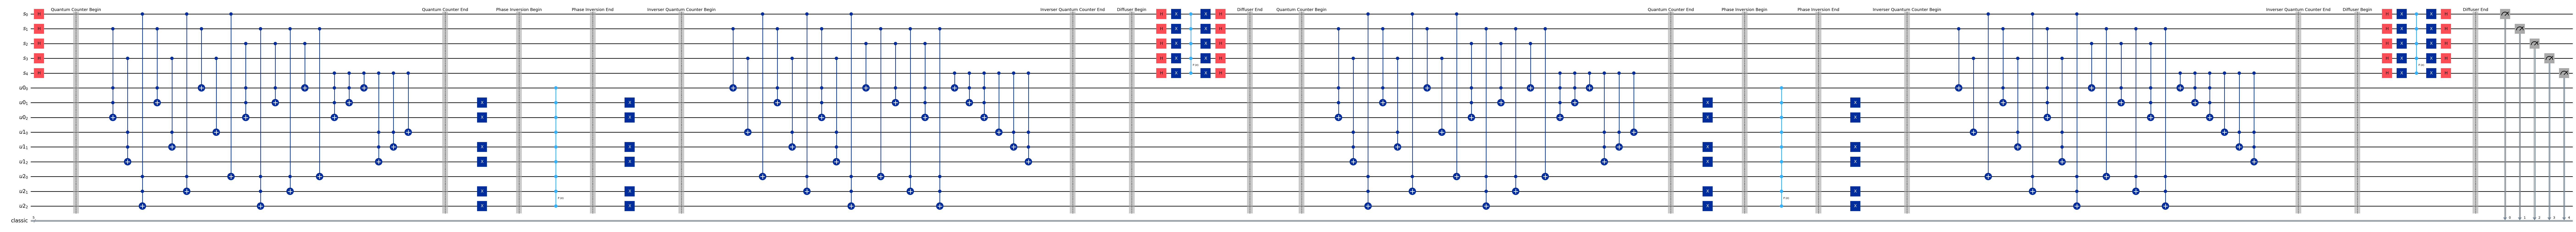

In [ ]:
# dataset-2
n = 5
m = math.ceil(math.log2(n))
N = math.pow(2, n)
M = 3 # known in advanced
repeat_times = math.floor(math.pi/4 * math.sqrt(N / M))

s = QuantumRegister(n, 's')
u0 = QuantumRegister(m, 'u0')
u1 = QuantumRegister(m, 'u1')
u2 = QuantumRegister(m, 'u2')
cr = ClassicalRegister(n, 'classic')
qc = QuantumCircuit(s, u0, u1, u2, cr)

qc.h(s)
for _ in range(repeat_times):
  qc.barrier(label='Quantum Counter Begin')
  # 0(u0) in subset B(s[1]), C(s[2]), E(s[4])
  add_one(qc, s[1], u0)
  add_one(qc, s[2], u0)
  add_one(qc, s[4], u0)
  # 1(u1) in subset D(s[3]), E(s[4])
  add_one(qc, s[3], u1)
  add_one(qc, s[4], u1)
  # 2(u2) in subset A(s[0]), B(s[1])
  add_one(qc, s[0], u2)
  add_one(qc, s[1], u2)
  qc.barrier(label='Quantum Counter End')
  qc.x(u0[1:])
  qc.x(u1[1:])
  qc.x(u2[1:])
  qc.barrier(label= 'Phase Inversion Begin')
  # add a negative phase for |111>
  all_u_bits = [*u0, *u1, *u2]
  qc.mcp(math.pi, all_u_bits[:-1], all_u_bits[-1])
  qc.barrier(label= 'Phase Inversion End')
  qc.x(u0[1:])
  qc.x(u1[1:])
  qc.x(u2[1:])
  qc.barrier(label= 'Inverser Quantum Counter Begin')
  add_one_inverse(qc, s[1], u0)
  add_one_inverse(qc, s[2], u0)
  add_one_inverse(qc, s[4], u0)
  add_one_inverse(qc, s[3], u1)
  add_one_inverse(qc, s[4], u1)
  add_one_inverse(qc, s[0], u2)
  add_one_inverse(qc, s[1], u2)
  qc.barrier(label= 'Inverser Quantum Counter End')
  qc.barrier(label= 'Diffuser Begin')
  diffusion(qc, s)
  qc.barrier(label= 'Diffuser End')
qc.measure(s, cr)
display(qc.draw('mpl', fold=-1))


In [ ]:
# Simualtion
sim = AerSimulator()
job = sim.run(qc, shots=1024)
result = job.result()
counts = result.get_counts()

for subset, freq in counts.items():
  # Take the result which has enough frequncy
  if freq > (1024 / 3) / 2:
    # Subset to corresponding symbol, note that the output from sim is from s4 to s1
    letters = ['E', 'D', 'C', 'B', 'A']
    symbol = [letters[i] for i in range(len(subset)) if subset[i] == '1']
    symbol.sort()
    print(f"Solutions are: {symbol}, Frequency: {freq}")

Solutions are: ['B', 'D'], Frequency: 321
Solutions are: ['A', 'C', 'D'], Frequency: 383
Solutions are: ['A', 'E'], Frequency: 320
